# R: Estimation of Price Elasticities with Double/Debiased Machine Learning

![](figures/demand.png)

In this example, we will demonstrate the use of the [DoubleML](https://docs.doubleml.org/stable/index.html) package in a real-data industry example: Estimation of price elasticity of demand. This notebook is based on a [blogpost by Lars Roemheld (Roemheld, 2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) with code and preprocessed data being available from [GitHub](https://github.com/larsroemheld/causalinf_ex_elasticity). The original data file is made available as a public domain (CC0 1.0 Universal) data set and shared on [kaggle](https://www.kaggle.com/vijayuv/onlineretail). It contains data on sales from an online retailer in the period of December 2010 until December 2011.

The data preprocessing is performed in a [separate notebook that is available online](https://github.com/DoubleML/doubleml-docs/blob/master/doc/examples/py_elasticity_preprocessing.ipynb). To keep the computational effort at a moderate level, we will only use a subset of the data that is used in [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b). Our main goal is to illustrate the main steps of elasticity estimation with [DoubleML](https://docs.doubleml.org/stable/index.html).

The following case study is organized according to the steps of the [DoubleML workflow](https://docs.doubleml.org/stable/workflow/workflow.html).

## 0. Problem Formulation: Estimation of Price Elasticity of Demand

"Supply" and "demand" are probably the very first terms that economics and business students hear in their studies. In industry, the price elasticity of demand is a very important quantity: It indicates how much the demand for a product (= the quantity sold by the firm) changes due to a change in its price. As a retailer, this quantity is of great interest because it makes it possible to increase revenues, and eventually profits, by optimally adjusting prices according to elasticities.

The price elasticity of demand is formally defined as the relative change of the demanded quantity ($q$) of a product given a percent-change of the price ($p$)

$$\theta_0 = \frac{\partial q/q}{\partial p/p}.$$

In words, the parameter $\theta_0$ can be interpreted as follows: Provided the price for a product increases by $1\%$, the demanded quantity changes by $\theta_0\%$.

In general, it would be possible to estimate $\theta_0$ based on an experiment or A/B test. However, this is not possible in our case as the data set only contains information on actual purchases in the period of consideration.

The causal problem of price estimation based on an observational study is quite complex: It involves many (simultaneous) decisions made by the customers and the sellers. One approach for estimation of the causal parameter $\theta_0$ would be to account for confounding variables, that might have an effect to both the price and the quantity sold. The approach taken in  [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) is to flexibly account for and construct confounding variables, for example including similarities in their product description or seasonal patterns, and thereby justifying identification of $\theta_0$.

We can use a [partially linear regression](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) (PLR) model for estimation of $\theta_0$

$$\log Q = \theta_0 \log P + g_0(X) + \zeta,$$

with $\mathbb{E}(\zeta|D,X)=0$. The confounders can enter the regression equation nonlinearily via the function $g_0(X)$. In order to equip $\theta_0$ (approximately) with the interpretation of a price elasticity, we applied the $\log()$ to both the demanded quantity ($Q$) and the prices ($P$), i.e., we set up a $\log$-$\log$-regression.

Before we proceed with the data analysis, it is important to mention a potential drawback to our analysis: The data only contains information on sales, not on stock days. Hence, based on this data set, it is not possible to assess what happened on days without sales (sales = 0). This drawback must be kept in mind when we draw causal conclusions from this analysis.

## 1. Data-Backend

To give an idea on the general setting we briefly load an exemplary data excerpt from the original data set. We can see that the data lists the transaction of a (online) retailer selling products like inflatable political globes or fancy pens.

In [1]:
# load required packages
library(data.table)
library(mlr3)
library(mlr3learners)
library(DoubleML)
library(ggplot2)

# suppress messages during fitting
lgr::get_logger("mlr3")$set_threshold("warn")

Warning message:
"package 'data.table' was built under R version 4.0.5"
Warning message:
"package 'mlr3' was built under R version 4.0.5"


In [2]:
# Load example data set from URL
url = 'https://raw.githubusercontent.com/DoubleML/doubleml-docs/master/doc/examples/data/orig_demand_data_example.csv'
data_example = fread(url)
data_example

V1,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice
<int>,<date>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.850
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.850
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.850
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.850
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.510
5,2010-12-01,11001,United Kingdom,ASSTD DESIGN RACING CAR PEN,3,10.08,3.360
6,2010-12-01,15044B,United Kingdom,BLUE PAPER PARASOL,1,2.95,2.950
7,2010-12-01,15056BL,United Kingdom,EDWARDIAN PARASOL BLACK,20,113.00,5.650
8,2010-12-01,15056N,United Kingdom,EDWARDIAN PARASOL NATURAL,50,236.30,4.726


In our analysis, we will use a preprocessed data set. Each row corresponds to the sales of a product at a specific date $t$.

In the data we have, 

* `Quantity`: Quantity demanded
* `revenue`: Revenue
* `UnitPrice`: Price per unit
* `month`: Month
* `DoM`: Day of month
* `DoW`: Day of week
* `stock_age_days`: Number of days product has been sold / observed in the data
* `sku_avg_p`: Average (=median) price of the product
* `2010-12-01`, ...: Date dummies
* `Australia`, ...: Country dummies
* `1`, `2`, ... : Numerical variables constructed to capture similarities in product descriptions (n-grams)
* `dLnP`: Change in Price
* `dLnQ`: Change in Quantity

Note that we do not include product dummies as the price and quantity variables have been demeaned to account for product characteristics.

In [3]:
# Load data set from URL
url2 = 'https://raw.githubusercontent.com/DoubleML/doubleml-docs/master/doc/examples/data/elasticity_subset.csv'
demand_data = fread(url2)

# Replace column names by names that are conform to R
names(demand_data) = make.names(names(demand_data), unique = TRUE)

# replace
names(demand_data)[1:20]

[1] "V1"                   "Quantity"             "revenue"             
 [4] "UnitPrice"            "month"                "DoM"                 
 [7] "DoW"                  "stock_age_days"       "sku_avg_p"           
[10] "X2010.12.01.00.00.00" "X2010.12.02.00.00.00" "X2010.12.03.00.00.00"
[13] "X2010.12.05.00.00.00" "X2010.12.06.00.00.00" "X2010.12.07.00.00.00"
[16] "X2010.12.08.00.00.00" "X2010.12.09.00.00.00" "X2010.12.10.00.00.00"
[19] "X2010.12.12.00.00.00" "X2010.12.13.00.00.00"

In [4]:
# Print dimensions of data set
dim(demand_data)

[1] 10000   906

In [5]:
# Glimpse at first rows of data set
head(demand_data)

V1,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p,X2010.12.01.00.00.00,...,X544,X545,X546,X547,X548,X549,X550,X551,dLnP,dLnQ
<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
189628,5,8.15,1.630000,9,6,1,278,0.85,0,...,0,0,0,0,0,0,0,0,0.40861180,-1.01384000
37914,19,41.93,2.206842,1,25,1,55,2.10,0,...,0,0,0,0,0,0,0,0,-0.04881062,-0.30636793
80103,24,20.40,0.850000,3,31,3,120,0.85,0,...,0,0,0,0,0,0,0,0,-0.12710826,1.37147928
75019,12,23.40,1.950000,3,24,3,113,2.08,0,...,0,0,0,0,0,0,0,0,-0.22825574,-1.03448268
99878,4,39.80,9.950000,5,5,3,155,9.95,0,...,0,0,0,0,0,0,0,0,-0.03492181,-0.05088112
20013,1,1.25,1.250000,12,23,3,22,1.25,0,...,0,0,0,0,0,0,0,0,-0.22889026,-3.03970526


To initiate the data backend, we create a new [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) object. During instantiation, we assign the roles of the variables, i.e., `dLnQ` as the dependent var, `dLnP` as the treatment variable and the remaining variables as confounders.

In [6]:
feature_names = names(demand_data)[5:(dim(demand_data)[2]-2)]

In [7]:
data_dml = DoubleMLData$new(demand_data,
                            y_col = "dLnQ",
                            d_cols = 'dLnP',
                            x_cols = feature_names)
data_dml

================= DoubleMLData Object ==================


------------------ Data summary      ------------------
Outcome variable: dLnQ
Treatment variable(s): dLnP
Covariates: month, DoM, DoW, stock_age_days, sku_avg_p, X2010.12.01.00.00.00, X2010.12.02.00.00.00, X2010.12.03.00.00.00, X2010.12.05.00.00.00, X2010.12.06.00.00.00, X2010.12.07.00.00.00, X2010.12.08.00.00.00, X2010.12.09.00.00.00, X2010.12.10.00.00.00, X2010.12.12.00.00.00, X2010.12.13.00.00.00, X2010.12.14.00.00.00, X2010.12.15.00.00.00, X2010.12.16.00.00.00, X2010.12.17.00.00.00, X2010.12.19.00.00.00, X2010.12.20.00.00.00, X2010.12.21.00.00.00, X2010.12.22.00.00.00, X2010.12.23.00.00.00, X2011.01.04.00.00.00, X2011.01.05.00.00.00, X2011.01.06.00.00.00, X2011.01.07.00.00.00, X2011.01.09.00.00.00, X2011.01.10.00.00.00, X2011.01.11.00.00.00, X2011.01.12.00.00.00, X2011.01.13.00.00.00, X2011.01.14.00.00.00, X2011.01.16.00.00.00, X2011.01.17.00.00.00, X2011.01.18.00.00.00, X2011.01.19.00.00.00, X2011.01.20.00.00.00, X2011.01

## 2. Causal Model 

We already stated that a partially linear regression model in a $\log$-$\log$-specification will allow us to interpret the regression coefficient $\theta_0$ as the price elasticity of demand. We restate the main regression as well as the auxiliary regression that is required for orthogonality


$$\begin{aligned}\log Q &= \theta_0 \log P + g_0(X) + \zeta,\\
\log P &= m_0(X) + V\end{aligned},$$

with $\mathbb{E}(\zeta|D,X)=0$ and $\mathbb{E}(V|X)=0$. As stated above, we hope to justify the assumption $\mathbb{E}(\zeta|D,X)=0$ by sufficiently accounting for the confounding variables $X$.


## 3. ML Methods

We start with the linear regression model as a benchmark lerner for learning nuisance parameters $g_0(X)$ and $m_0(X)$. We additionally set up two models based on a lasso learner as well as a random forest learner and compare our results.

In [8]:
ml_l_lin_reg = lrn("regr.lm")
ml_m_lin_reg = lrn("regr.lm")

In [9]:
ml_l_lasso = lrn("regr.cv_glmnet", s = "lambda.min")
ml_m_lasso = lrn("regr.cv_glmnet", s = "lambda.min")

In [10]:
ml_l_forest = lrn("regr.ranger", num.trees = 50,
                  min.node.size = 3)
ml_m_forest = lrn("regr.ranger", num.trees = 50,
                  min.node.size = 3)

## 4. DML Specifications

For each learner configuration, we initialize a new [DoubleMLPLR](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html) object. We stick to the default options, i.e., `dml_procedure = 'dml2'`, `score = "partialling out"`, n_folds = 5. 

In [11]:
set.seed(123)
dml_plr_lin_reg = DoubleMLPLR$new(data_dml,
                                  ml_l = ml_l_lin_reg,
                                  ml_m = ml_m_lin_reg)

In [12]:
set.seed(123)
dml_plr_lasso = DoubleMLPLR$new(data_dml,
                                ml_l = ml_l_lasso,
                                ml_m = ml_m_lasso)                            

In [13]:
set.seed(123)
dml_plr_forest = DoubleMLPLR$new(data_dml,
                                 ml_l = ml_l_forest,
                                 ml_m = ml_m_forest)

## 5. Estimation 

To estimate our target parameter $\theta_0$, we call the `fit()` method. The results can be summarized by calling the `summary()` method.

In [14]:
dml_plr_lin_reg$fit(store_predictions = TRUE)
dml_plr_lin_reg$summary()

Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may 

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
dLnP  -1.83549    0.04343  -42.26   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [15]:
dml_plr_lasso$fit(store_predictions = TRUE)
dml_plr_lasso$summary()

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
dLnP  -1.81615    0.04381  -41.45   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [16]:
dml_plr_forest$fit(store_predictions = TRUE)
dml_plr_forest$summary()

Estimates and significance testing of the effect of target variables
     Estimate. Std. Error t value Pr(>|t|)    
dLnP  -1.80559    0.04359  -41.43   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [17]:
# Define function for RMSE of nuisance components
pred_acc_plr = function(obj, nuis) {
    # A function to calculate prediction accuracy values for every repetition
    # of a Double Machine Learning model using PLR, DoubleMLPLR
    
    # Parameters
    # DoubleML: DoubleML::DoubleMLPLR 
        # A DoubleML PLR model object
    # nuis: character (1l)
        # Indicates nuisance component for evaluation of RMSE, either
        # 'ml_l' or 'ml_m'
    
    # Export data, fitted coefficient and predictions of the DoubleML model
    y = obj$data$data_model[[obj$data$y_col]]
    d = obj$data$data_model[[obj$data$treat_col]]
    theta = obj$coef
    ml_nuis = obj$predictions[[nuis]]
    
    # Dimensions of prediction array
    h = obj$data$n_obs
    
    if (nuis == "ml_l") {
        export_pred = theta*d + ml_nuis
    } else if (nuis == "ml_m") {
        export_pred = ml_nuis
    }    
    rmse = mlr3measures::rmse(y, ml_nuis)
    return(rmse)
}

In [18]:
rmse_lin_reg_ml_l = pred_acc_plr(dml_plr_lin_reg, 'ml_l')
rmse_lin_reg_ml_m = pred_acc_plr(dml_plr_lin_reg, 'ml_m')

In [19]:
rmse_lasso_ml_l = pred_acc_plr(dml_plr_lasso, 'ml_l')
rmse_lasso_ml_m = pred_acc_plr(dml_plr_lasso, 'ml_m')

In [20]:
rmse_forest_ml_l = pred_acc_plr(dml_plr_forest, 'ml_l')
rmse_forest_ml_m = pred_acc_plr(dml_plr_forest, 'ml_m')

In [21]:
estimators = c("regression", "lasso", "forest")
estimators = ordered(estimators, levels = estimators)

plr_rmse = data.table(
    "ML" = estimators,
    "RMSE" = c(rmse_lin_reg_ml_l, rmse_lasso_ml_l,
               rmse_forest_ml_l,              
               rmse_lin_reg_ml_m, rmse_lasso_ml_m,
               rmse_forest_ml_m),
    "nuis" = c(rep("ml_l", 3), rep("ml_m", 3)))

In [22]:
plr_rmse

ML,RMSE,nuis
<ord>,<dbl>,<chr>
regression,1.133228,ml_l
lasso,1.104634,ml_l
forest,1.087215,ml_l
regression,1.295019,ml_m
lasso,1.287731,ml_m
forest,1.289340,ml_m


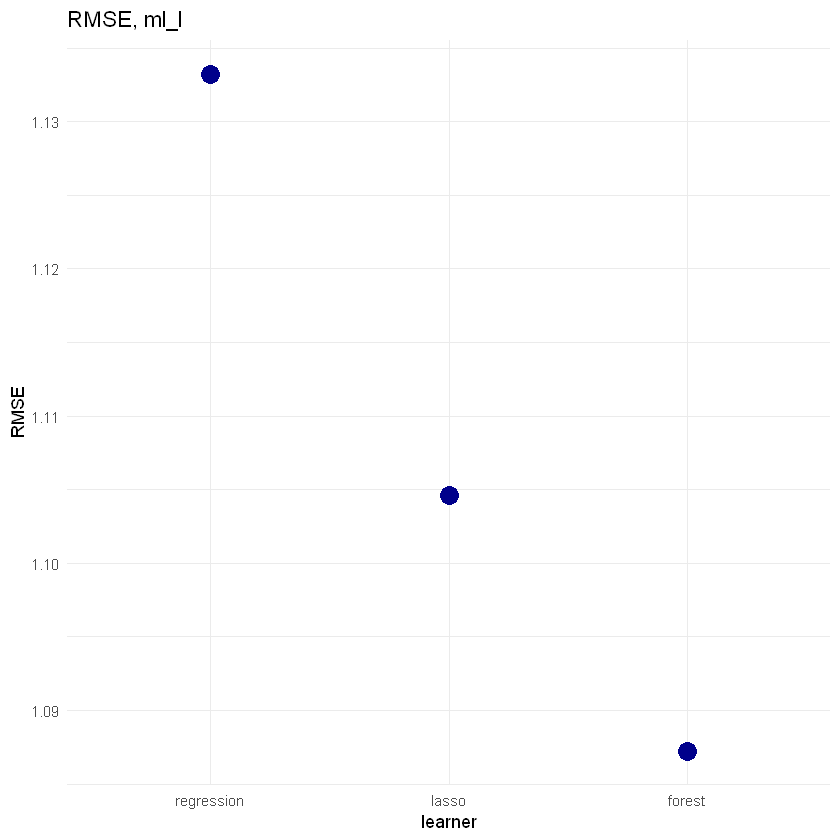

In [23]:
g_rmse_ml_l = ggplot(plr_rmse[nuis == 'ml_l',], aes(x = ML, y = RMSE,
                                               fill = ML)) +
        geom_point(size = 5, color = "darkblue") +
        theme_minimal() + ylab("RMSE") +
        ggtitle("RMSE, ml_l") +
        xlab("learner") + theme(legend.position = "none")
g_rmse_ml_l

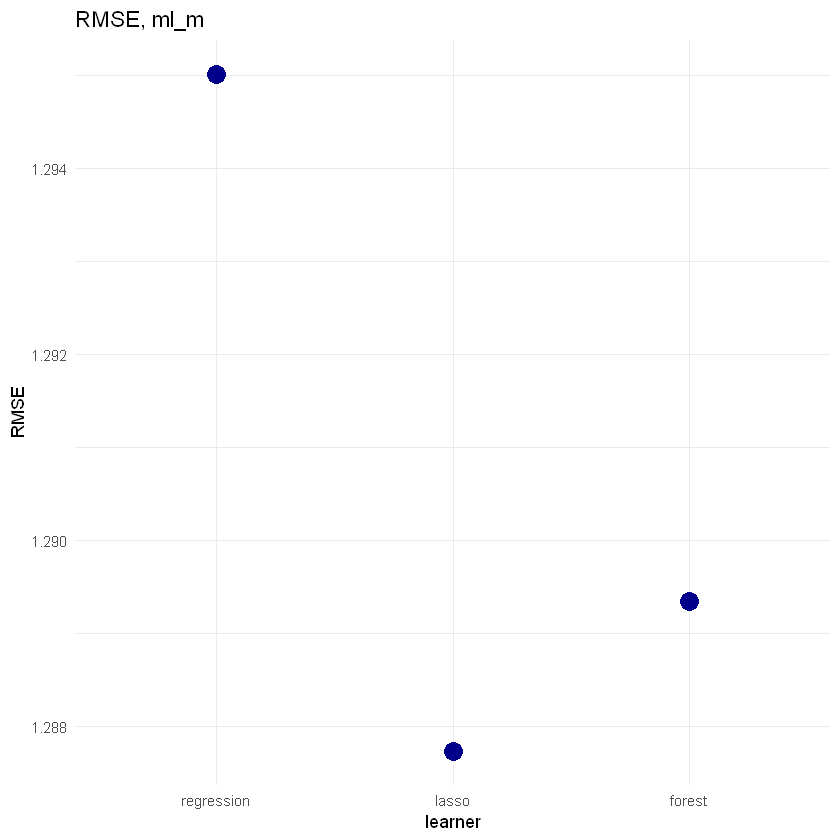

In [24]:
g_rmse_ml_m = ggplot(plr_rmse[nuis == 'ml_m',], aes(x = ML, y = RMSE,
                                               fill = ML)) +
        geom_point(size = 5, color = "darkblue") +
        theme_minimal() + ylab("RMSE") +
        ggtitle("RMSE, ml_m") +
        xlab("learner") + theme(legend.position = "none")
g_rmse_ml_m

## 7. Inference

We can visualize and summarize our findings so far. We can conclude that the price elasticity of demand, as indicated by the causal parameter $\theta_0$, is around $-1.8$. In all models, the coefficient is significantly different from zero.

In [25]:
models = list(dml_plr_lin_reg, dml_plr_lasso, dml_plr_forest)

In [26]:
plr_summary_list = lapply(models,
                    function(x) {
                        ci = x$confint()
                        return(list("coef" = x$coef,
                                    "lower" = ci[1],
                                    "upper" = ci[2]))
                        })

In [27]:
plr_summary = data.table::rbindlist(plr_summary_list)
plr_summary[, "ML" := estimators]

In [28]:
plr_summary

coef,lower,upper,ML
<dbl>,<dbl>,<dbl>,<ord>
-1.835487,-1.920613,-1.750361,regression
-1.816147,-1.902015,-1.730280,lasso
-1.805594,-1.891020,-1.720169,forest


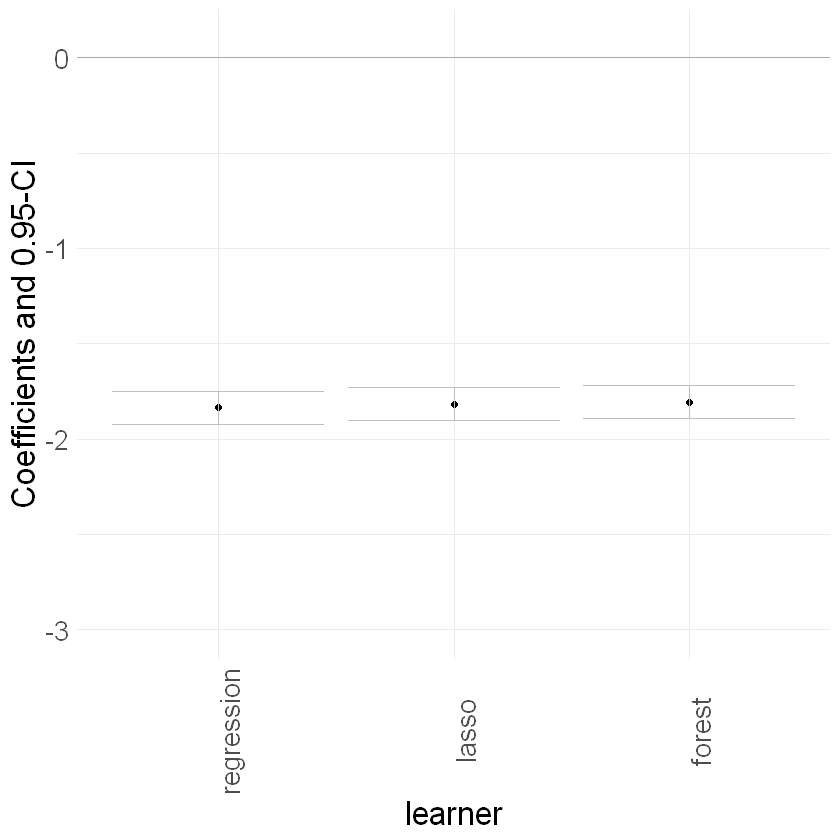

In [29]:
g_ci = ggplot(plr_summary, aes(x = ML, y = coef)) +
    geom_point() +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = "grey") +
    theme_minimal() + ylab("Coefficients and 0.95-CI") +
    xlab("learner") +
    theme(axis.text.x = element_text(angle = 90), legend.position = "none",
          text = element_text(size = 20)) + 
    geom_hline(yintercept = 0, color = "darkgrey") +
    ylim(-3, 0.1)

g_ci

______

**Acknowledgement**

We would like to thank [Lars Roemheld](https://www.larsroemheld.com/) for setting up the blog post on demand estimation using double machine learning as well as for sharing the code and preprocessed data set. We hope that with this notebook, we illustrate how to run such an analysis using [DoubleML](https://docs.doubleml.org/stable/index.html). Moreover, we would like to thank [Anzony Quispe](https://github.com/anzonyquispe) for excellent assistance in creating this notebook.
